In [1]:
import skimage
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20

### Write stacks for visual inspection

In [ ]:
data_dir = Path('/lab/raw-data/ALS0002_NGN2_DIV11_MG132DRCv3/DIV11 v3 lower AF488__2023-02-15T08_40_16-Measurement 1')
save_dir = Path('/lab/processed-data/ALS0002_NGN2_DIV11_MG132DRCv3/DIV11 v3 lower AF488__2023-02-15T08_40_16-Measurement 1')
pm = pd.read_csv(save_dir / '2023-02-17_tdp43seg_tdp-43' / '2023-02-17_tdp43seg_tdp-43Image.csv')
pm['filename'] = pm['FileName_TDP43']
# img_dir = 'Images'
img_dir = '2023-02-17_tdp43seg_tdp-43/soma_outlines'
img_stack = np.zeros((pm.shape[0], 1080, 1080))
img_stack = img_stack.astype('uint16')
for i_file, file in enumerate(pm['filename']):
    tif = skimage.io.imread(save_dir / img_dir / (file))
    # tif = skimage.io.imread(data_dir / img_dir / (file))
    img_stack[i_file, :, :] = tif
# img_stack 
tifffile.imwrite(save_dir / '2023-02-17_tdp43seg_tdp-43' / ('soma_outlines.tiff'), img_stack, metadata={'axes': 'ZYX'}, imagej=True, compression='lzw', dtype='uint16')
# tifffile.imwrite(save_dir / ('max_projections_HOESCHT.tiff'), img_stack, metadata={'axes': 'ZYX'}, imagej=True, compression='lzw', dtype='uint16')

In [2]:
data_dir = Path('/lab/processed-data/ALS0002_NGN2_DIV11_MG132DRCv3/DIV11 v3 lower AF488__2023-02-15T08_40_16-Measurement 1')
analysis_name = '2023-02-17_tdp43seg_tdp-43'
image_data = pd.read_csv(data_dir / 
                         analysis_name /
                         (analysis_name + 'Image.csv'))
soma_data = pd.read_csv(data_dir / 
                         analysis_name /
                         (analysis_name + 'cytoplasm_outlines.csv'))
nuclei_data = pd.read_csv(data_dir / 
                         analysis_name /
                         (analysis_name + 'nuclei.csv'))


In [5]:
measurement = 'Intensity_IntegratedIntensity_'
channels = ['TDP43_corrected']

ratio_data = pd.DataFrame(index = soma_data.index, 
                          columns = channels)
n_cells = soma_data.shape[0]
ratio_data['row'] = np.zeros(n_cells)
ratio_data['col'] = np.zeros(n_cells)
ratio_data['concentration'] = np.zeros(n_cells)
ratio_data['ImageNumber'] = soma_data['ImageNumber']

# Create ratio data
# for ch in channels:
    # ratio_data[ch] = ((soma_data[measurement + ch] - 
    #                    nuclei_data[measurement + ch]) / 
    #                   nuclei_data[measurement + ch])
    # ratio_data[ch].loc[ratio_data['ImageNumber'] == 1] = 1

# Add raw data columns to dataframe
ratio_data['TDP43_nucleus'] = nuclei_data[measurement + channels[0]] / nuclei_data['AreaShape_Area']
ratio_data['TDP43_cytoplasm'] = (soma_data[measurement + channels[0]] - 
                                 nuclei_data[measurement + channels[0]]) /  (soma_data['AreaShape_Area'] - nuclei_data['AreaShape_Area'])
ratio_data['TDP43_ratio'] = (ratio_data['TDP43_cytoplasm'] / 
                             ratio_data['TDP43_nucleus'])


# Create lookup table for rows-concentrations
conc_lookup = {'02' : 2e-6,
               '03' : 1e-6,
               '04' : 500e-9,
               '05' : 250e-9,
               '06' : 125e-9,
               '07' : 062.5e-9}

# Assign each cell a row & column index, and concentration (condition)
for i_cell in np.arange(n_cells):
    ratio_data['row'].iloc[i_cell] = soma_data['FileName_DAPI'].iloc[i_cell][1:3]
    ratio_data['col'].iloc[i_cell] = soma_data['FileName_DAPI'].iloc[i_cell][4:6]
    ratio_data['concentration'].iloc[i_cell] = conc_lookup[ratio_data['row'].iloc[i_cell]]

# Remove first image, which is unlabeled
ratio_data = ratio_data.drop(index=1)
n_cells = ratio_data.shape[0]
ratio_data.index = np.arange(n_cells)

n_cells = ratio_data.shape[0]
ratio_data.index = np.arange(n_cells)

/tmp/ipykernel_4551/1604715794.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_data['row'].iloc[i_cell] = soma_data['FileName_DAPI'].iloc[i_cell][1:3]
/tmp/ipykernel_4551/1604715794.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_data['col'].iloc[i_cell] = soma_data['FileName_DAPI'].iloc[i_cell][4:6]
/tmp/ipykernel_4551/1604715794.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_data['concentration'].ilo

In [ ]:
# ratio_data['condition'] = ratio_data['row'] + ratio_data['col'] 
data = ratio_data.groupby(['row', 'col']).mean()
data = data.reset_index()

In [ ]:
row_lookup = {'02' : 2e-6,
               '03' : 1e-6,
               '04' : 500e-9,
               '05' : 250e-9,
               '06' : 125e-9,
               '07' : 062.5e-9}
# row_lookup = pd.Series(row_lookup)

col_lookup = {'02' : 'DMSO',
                '03' : 'MG132',
                '04' : 'MG132',
                '05' : 'BTZ',
                '06' : 'BTZ'}
                
pal = [[0, 0, 0], [0.9, 0, 0]]
# ratio_data.loc[ratio_data['col'] == '2', 'col'] = '1'
# data['condition'] = data['concentration']
# data = ratio_data.drop(ratio_data.index[ratio_data['ImageNumber'] == 1])
# data = ratio_data.groupby(['row', 'col']).mean()
# data = data.reset_index()
data = ratio_data.copy()
row = '04'
data.loc[data['col'] == '02', 'row'] = row
data.loc[data['col'] == '05', 'col'] = '06'
data = data.query('col==["02","04"]')
# data = data.query('row==@row')
data['row'] = [str(row_lookup[r]) for r in data['row']]
data['col'] = [col_lookup[c] for c in data['col']]
data['condition'] = data['row'] + data['col']
# data.loc[data['condition']== row + '02', 'condition'] = 'DMSO'
# data.loc[data['condition']== row + '04', 'condition'] = '0.5uM BTZ'
ngn2_data = data.copy()
fig, axs = plt.subplots(1,2)
# sns.histplot(ax=axs[0], data=data, x='TDP43_corrected', hue='col', kde=True, common_bins=True, stat='density', common_norm=False)
axs[0].set_xlabel('TDP-43 ratio (mean cyto. / mean nuc.)')
axs[0].set_ylabel('probability density')
sns.histplot(ax=axs[0], data=data, x='TDP43_ratio', hue='condition', stat='density', kde=True, common_bins=True, common_norm=False, palette=pal, multiple="layer")
axs[0].set_xlim([0, 2])
sns.histplot(ax=axs[1], data=data, x='TDP43_ratio', hue='condition', stat='density', kde=True, common_bins=True, common_norm=False, cumulative=True, palette=pal, multiple="layer")
axs[1].set_xlabel('TDP-43 ratio (mean cyto. / mean nuc.)')
axs[1].set_ylabel('cumulative density')
plt.legend([])
plt.xlim([0, 2])
plt.suptitle('DIV11 v3 lower AF488__2023-02-15T08_40_16-Measurement 1')

/tmp/ipykernel_2428/701882775.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['row', 'col']).mean()
/tmp/ipykernel_2428/701882775.py:26: UserWarning: 
The palette list has fewer values (2) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(ax=axs[0], data=data, x='TDP43_ratio', hue='condition', stat='density', kde=True, common_bins=True, common_norm=False, palette=pal, multiple="layer")
/tmp/ipykernel_2428/701882775.py:31: UserWarning: 
The palette list has fewer values (2) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(ax=axs[1], data=data, x='TDP43_ratio', hue='condition', stat='density', kde=True, common_bins=True, common_norm=False, cumulative=True, palette=pal, multiple="layer")


Text(0.5, 0.98, 'DIV11 v3 lower AF488__2023-02-15T08_40_16-Measurement 1')

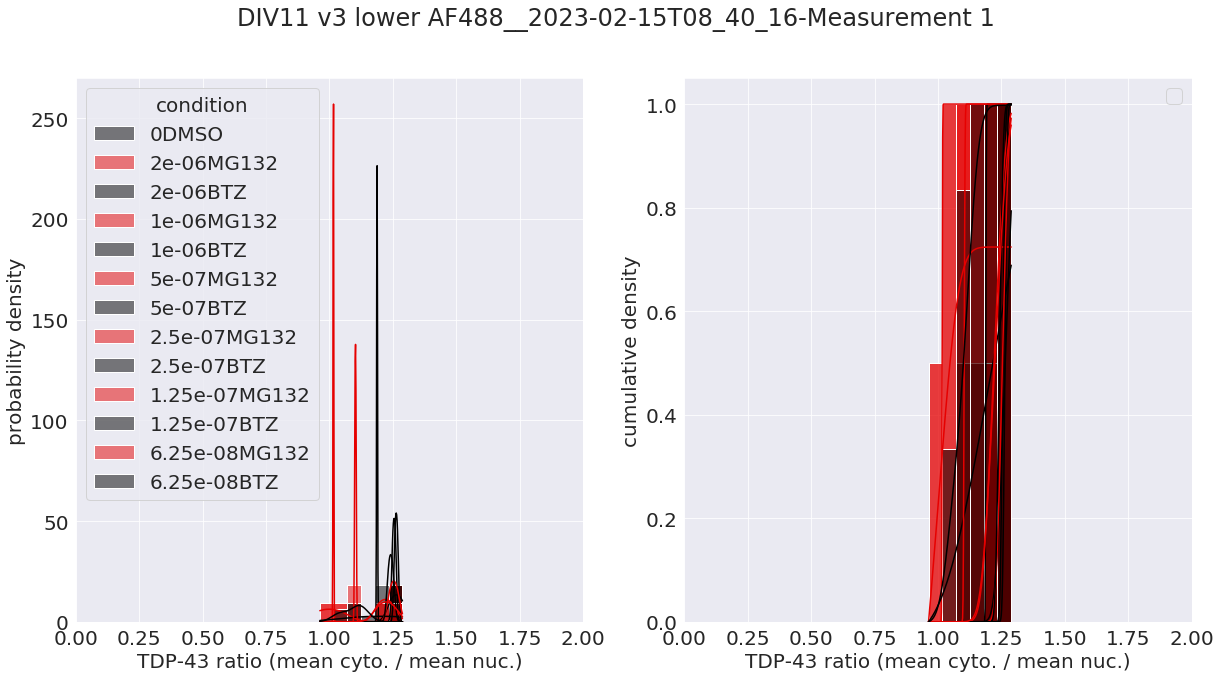

In [55]:
row_lookup = {'07' : 062.5e-9,
            '06' : 125e-9,
            '05' : 250e-9,
            '04' : 500e-9,
            '03' : 1e-6,
            '02' : 2e-6,
            '00' : 0}  

col_lookup = {'02' : 'DMSO',
                '03' : 'MG132',
                '04' : 'MG132',
                '05' : 'BTZ',
                '06' : 'BTZ'}
                
pal = [[0, 0, 0], [0.9, 0, 0]]
data = ratio_data.copy()
data = data.groupby(['row', 'col']).mean()
data = data.reset_index()
data.loc[data['col'] == '02', 'row'] = '00'
data['row'] = [str(row_lookup[r]) for r in data['row']]
data['col'] = [col_lookup[c] for c in data['col']]
data['condition'] = data['row'] + data['col']

fig, axs = plt.subplots(1,2)

sns.histplot(ax=axs[0], data=data, x='TDP43_ratio', hue='condition', stat='density', kde=True, common_bins=True, common_norm=False, palette=pal, multiple="layer")
axs[0].set_xlabel('TDP-43 ratio (mean cyto. / mean nuc.)')
axs[0].set_ylabel('probability density')
axs[0].set_xlim([0, 2])

sns.histplot(ax=axs[1], data=data, x='TDP43_ratio', hue='condition', stat='density', kde=True, common_bins=True, common_norm=False, cumulative=True, palette=pal, multiple="layer")
axs[1].set_xlabel('TDP-43 ratio (mean cyto. / mean nuc.)')
axs[1].set_ylabel('cumulative density')
plt.legend([])
plt.xlim([0, 2])
plt.suptitle('DIV11 v3 lower AF488__2023-02-15T08_40_16-Measurement 1')


(array([-2.50e-07,  0.00e+00,  2.50e-07,  5.00e-07,  7.50e-07,  1.00e-06,
         1.25e-06,  1.50e-06,  1.75e-06,  2.00e-06,  2.25e-06]),
 <a list of 11 Text xticklabel objects>)

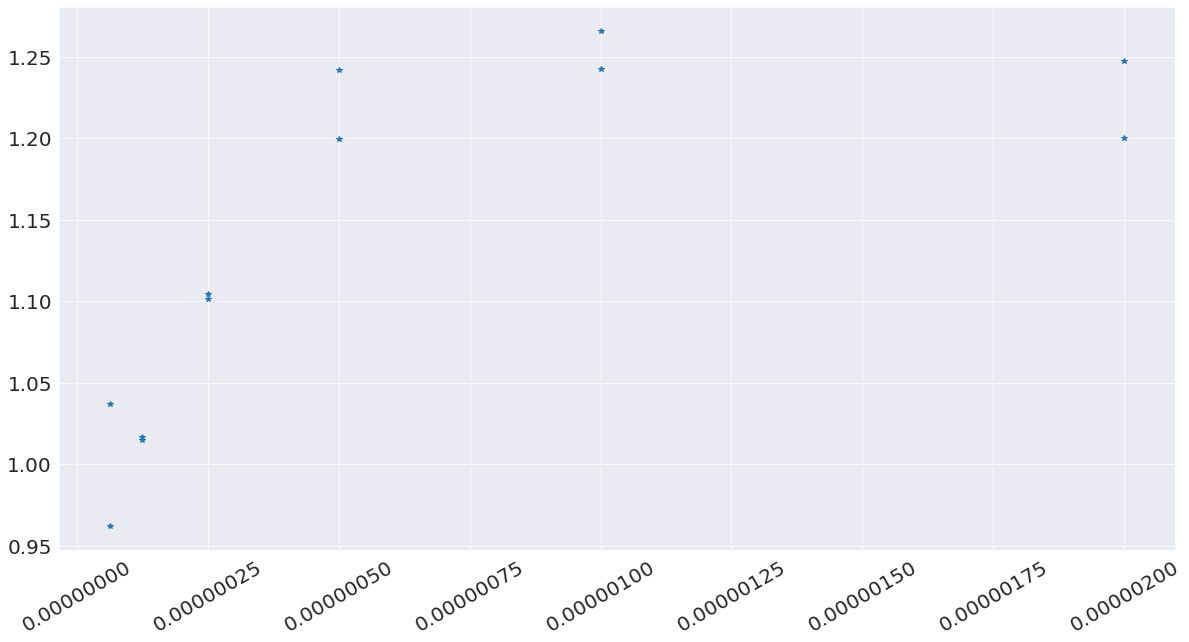

In [63]:
sns.set_style('darkgrid')
d = data.query('col=="MG132"')
plt.plot(d['row'].astype('float'), d['TDP43_ratio'], '*')
# plt.ylim([0.6, 1.2])
plt.xticks(rotation = 30)

In [62]:
d['row'].astype('float')

1     2.000000e-06
2     2.000000e-06
6     1.000000e-06
7     1.000000e-06
11    5.000000e-07
12    5.000000e-07
16    2.500000e-07
17    2.500000e-07
21    1.250000e-07
22    1.250000e-07
26    6.250000e-08
27    6.250000e-08
Name: row, dtype: float64

In [58]:
d

,row,col,concentration,ImageNumber,TDP43_nucleus,TDP43_cytoplasm,TDP43_ratio,condition
1,2e-06,MG132,2.000000e-06,22.541524,0.158073,0.189069,1.247336,2e-06MG132
2,2e-06,MG132,2.000000e-06,37.134474,0.183241,0.210135,1.200003,2e-06MG132
6,1e-06,MG132,1.000000e-06,97.701166,0.165021,0.200840,1.265414,1e-06MG132
7,1e-06,MG132,1.000000e-06,112.367463,0.177820,0.208724,1.242321,1e-06MG132
11,5e-07,MG132,5.000000e-07,173.064935,0.160481,0.190014,1.241588,5e-07MG132
12,5e-07,MG132,5.000000e-07,188.113744,0.167328,0.189849,1.199555,5e-07MG132
16,2.5e-07,MG132,2.500000e-07,248.339513,0.171475,0.175411,1.104614,2.5e-07MG132
17,2.5e-07,MG132,2.500000e-07,263.149724,0.161650,0.166853,1.101248,2.5e-07MG132
21,1.25e-07,MG132,1.250000e-07,324.536680,0.144101,0.138400,1.016955,1.25e-07MG132
22,1.25e-07,MG132,1.250000e-07,338.692068,0.133655,0.126584,1.015201,1.25e-07MG132


In [52]:
a = 2e-06
data.query('col=="DMSO"')

,row,col,concentration,ImageNumber,TDP43_nucleus,TDP43_cytoplasm,TDP43_ratio,condition
0,0,DMSO,2.000000e-06,9.152330,0.009746,0.009944,1.030997,0DMSO
5,0,DMSO,1.000000e-06,83.687084,0.153025,0.158817,1.104540,0DMSO
10,0,DMSO,5.000000e-07,158.653061,0.132325,0.141210,1.143956,0DMSO
15,0,DMSO,2.500000e-07,233.792890,0.129835,0.136440,1.121896,0DMSO
20,0,DMSO,1.250000e-07,309.503608,0.129022,0.136457,1.112616,0DMSO
25,0,DMSO,6.250000e-08,384.701897,0.156740,0.153260,1.052556,0DMSO


In [50]:
data

,row,col,concentration,ImageNumber,TDP43_nucleus,TDP43_cytoplasm,TDP43_ratio,condition
0,0,DMSO,2.000000e-06,9.152330,0.009746,0.009944,1.030997,0DMSO
1,2e-06,MG132,2.000000e-06,22.541524,0.158073,0.189069,1.247336,2e-06MG132
2,2e-06,MG132,2.000000e-06,37.134474,0.183241,0.210135,1.200003,2e-06MG132
3,2e-06,BTZ,2.000000e-06,51.474257,0.155999,0.183674,1.234903,2e-06BTZ
4,2e-06,BTZ,2.000000e-06,66.278652,0.152867,0.180937,1.248872,2e-06BTZ
5,0,DMSO,1.000000e-06,83.687084,0.153025,0.158817,1.104540,0DMSO
6,1e-06,MG132,1.000000e-06,97.701166,0.165021,0.200840,1.265414,1e-06MG132
7,1e-06,MG132,1.000000e-06,112.367463,0.177820,0.208724,1.242321,1e-06MG132
8,1e-06,BTZ,1.000000e-06,126.071220,0.151966,0.182776,1.259440,1e-06BTZ
9,1e-06,BTZ,1.000000e-06,141.290214,0.147039,0.179492,1.268073,1e-06BTZ


In [ ]:
data_dir = Path('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1')
analysis_name = '2023-02-17_tdp43seg_tdp-43'
image_data = pd.read_csv(data_dir / 
                         analysis_name /
                         (analysis_name + 'Image.csv'))
soma_data = pd.read_csv(data_dir / 
                         analysis_name /
                         (analysis_name + 'cytoplasm_outlines.csv'))
nuclei_data = pd.read_csv(data_dir / 
                         analysis_name /
                         (analysis_name + 'nuclei.csv'))


In [ ]:
measurement = 'Intensity_IntegratedIntensity_'
channels = ['TDP43_corrected']

ratio_data = pd.DataFrame(index = soma_data.index, 
                          columns = channels)
n_cells = soma_data.shape[0]
ratio_data['row'] = np.zeros(n_cells)
ratio_data['col'] = np.zeros(n_cells)
ratio_data['concentration'] = np.zeros(n_cells)
ratio_data['ImageNumber'] = soma_data['ImageNumber']

# Create ratio data
# for ch in channels:
    # ratio_data[ch] = ((soma_data[measurement + ch] - 
    #                    nuclei_data[measurement + ch]) / 
    #                   nuclei_data[measurement + ch])
    # ratio_data[ch].loc[ratio_data['ImageNumber'] == 1] = 1

# Add raw data columns to dataframe
ratio_data['TDP43_nucleus'] = nuclei_data[measurement + channels[0]] / nuclei_data['AreaShape_Area']
ratio_data['TDP43_cytoplasm'] = (soma_data[measurement + channels[0]] - 
                                 nuclei_data[measurement + channels[0]]) /  (soma_data['AreaShape_Area'] - nuclei_data['AreaShape_Area'])
ratio_data['TDP43_ratio'] = (ratio_data['TDP43_cytoplasm'] / 
                             ratio_data['TDP43_nucleus'])
# ratio_data['TDP43_ratio'] = soma_data[measurement + channels[0]]

# Create lookup table for rows-concentrations
conc_lookup = {'02' : 2e-6,
               '03' : 1e-6,
               '04' : 500e-9,
               '05' : 250e-9,
               '06' : 125e-9,
               '07' : 062.5e-9}

# Assign each cell a row & column index, and concentration (condition)
for i_cell in np.arange(n_cells):
    ratio_data['row'].iloc[i_cell] = soma_data['FileName_DAPI'].iloc[i_cell][1:3]
    ratio_data['col'].iloc[i_cell] = soma_data['FileName_DAPI'].iloc[i_cell][4:6]
    ratio_data['concentration'].iloc[i_cell] = conc_lookup[ratio_data['row'].iloc[i_cell]]

# Remove first image, which is unlabeled
ratio_data = ratio_data.drop(index=1)
n_cells = ratio_data.shape[0]
ratio_data.index = np.arange(n_cells)

n_cells = ratio_data.shape[0]
ratio_data.index = np.arange(n_cells)

In [ ]:
data = ratio_data.copy()
data = data.groupby(['row', 'col']).mean()
data = data.reset_index()
ratio_data

In [ ]:
row_lookup = {'02' : '0',
               '03' : '0',
               '04' : '0',
               '05' : '2',
               '06' : '0.5',
               '07' : '0.25'}
# row_lookup = pd.Series(row_lookup)

col_lookup = {'03' : 'NT',
                '04' : 'UNC13A',
                '05' : 'C9ORF72',
                '06' : 'SCFD1',
                '07' : 'RANBP10',
                '08' : 'ZDHHC6',
                '09' : 'ZNF142',
                '10' : 'RESP18'}
# col_lookup = pd.Series(col_lookup)
pal = [[0, 0, 0], [0.9, 0, 0]]
# ratio_data.loc[ratio_data['col'] == '2', 'col'] = '1'
# data['condition'] = data['concentration']
# data = ratio_data.drop(ratio_data.index[ratio_data['ImageNumber'] == 1])
# data = ratio_data.groupby(['row', 'col']).mean()
# data = data.reset_index()

# data = ratio_data.copy()
data['condition'] = data['row'] + data['col']
data = data.drop(data.index[data['condition'] == '0203'])
# data = data.drop(data.index[data['row'] == '02'])
# for col in col_lookup.keys():
row = '03' 
col='07'
data.loc[data['row'] == '02', 'row'] = row
data.loc[data['row'] == '03', 'row'] = row
data.loc[data['row'] == '04', 'row'] = row
data = data.query('row==["03","06"]')
# data = data.query('col==["03", @col]')
data['row'] = [row_lookup[r] for r in data['row']]
data['col'] = [col_lookup[c] for c in data['col']]
data['condition'] = data['row'] + data['col']
# for i in np.arange(data.shape[0]):
#     data['condition'].iloc[i] = str(row_lookup[data.iloc[i]['row']]) + '_' + col_lookup[data.iloc[i]['col']] 
# data.loc[data['condition']== row + '02', 'condition'] = 'DMSO'
# data.loc[data['condition']== row + '06', 'condition'] = '0.5uM MG132'
ngn2_data = data.copy()
fig, axs = plt.subplots(1,2)
# sns.histplot(ax=axs[0], data=data, x='TDP43_corrected', hue='col', kde=True, common_bins=True, stat='density', common_norm=False)
axs[0].set_xlabel('TDP-43 ratio (mean cyto. / mean nuc.)')
axs[0].set_ylabel('probability density')
sns.histplot(ax=axs[0], data=data, x='TDP43_ratio', hue='condition', stat='density', kde=True, common_bins=True, common_norm=False, multiple="layer")
axs[0].set_xlim([0, 2])
sns.histplot(ax=axs[1], data=data, x='TDP43_ratio', hue='condition', stat='density', kde=True, common_bins=True, common_norm=False, cumulative=True,  multiple="layer")
axs[1].set_xlabel('TDP-43 ratio (mean cyto. / mean nuc.)')
axs[1].set_ylabel('cumulative density')
plt.legend([])
plt.xlim([0, 2])
plt.suptitle('DIV11 v3 lower AF488__2023-02-15T08_40_16-Measurement 1')
    # plt.show()

In [ ]:
data = data.drop(data.index[data['TDP43_ratio'].isna()])


In [ ]:
data.condition.unique()
from scipy.stats import ttest_ind

In [ ]:
results = np.zeros([data.condition.unique()[:8].shape[0], 2])
results = pd.DataFrame(results, index = data.condition.unique()[:8], columns = ['t-stat', 'p-value'])
for gene in data.condition.unique()[:8]:
    cat1 = data[data['condition']==gene]
    cat2 = data[data['condition']=='0NT']

    results.loc[gene] = ttest_ind(cat1['TDP43_ratio'], cat2['TDP43_ratio'])

In [ ]:
data.condition.unique()

In [ ]:
results

In [ ]:
0.014736 * 7

In [ ]:
pal = [[0.5, 0.5, 0.5], [0.9, 0, 0]]
# sns.violinplot(ax=axs[0], data=ngn2_data, y='TDP43_ratio', x='condition', palette=pal, saturation=0.3)
ax = sns.boxplot(ax=axs[0], data=data, y='TDP43_ratio', x='condition', palette=pal, saturation=0.3, showfliers=False)
# pal = [[0.3, 0.3, 0.3], [0.7, 0, 0]]
# sns.swarmplot(ax=axs[0], data=ngn2_data, y='TDP43_ratio', x='condition', palette=pal, size=10, linewidth=2) 
pairs=[("0RESP18", "0NT"), ("0SCFD1", "0NT"), ("ZDHHC6", "0NT")]
# pairs = [("0RESP18", "0NT"), ("0SCFD1", "0NT"), ("ZDHHC6", "0NT")]
annotator = Annotator(ax, pairs, data=data, x='condition', y='TDP43_ratio')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

In [ ]:
sns.set_style('darkgrid')
sns.boxplot(data=data.query('row=="0"'), y='TDP43_ratio', x='condition', saturation=0.3, showfliers=False)
plt.ylim([0.6, 1.2])
plt.xticks(rotation = 30)

In [ ]:
sns.set_style('darkgrid')
sns.boxplot(data=data.query('row=="0"'), y='TDP43_ratio', x='condition', saturation=0.3, showfliers=False)
plt.ylim([0, 1.75])
plt.xticks(rotation = 30)

In [ ]:
data.shape[0] / 8

In [ ]:
data